# Statistical physics of graphs and networks
## *Project:* study of the configuration model of random graphs
### *Master in physics of complex systems*
Joseph Touzet

We first import a few packages:

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import scipy.optimize as opt
import copy

We will use _networkx_ to manage and plot networks.

We also define the parameter for ploting networks:

In [2]:
options = {
    "with_labels": False,
    "node_size": 3,
    "node_color": "black",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 3,
}

def plot_graph(gr):
    pos = nx.nx_agraph.graphviz_layout(gr, prog="neato")
    
    C = (gr.subgraph(c) for c in nx.connected_components(gr))
    for g in C:
        c = [np.random.random()] * nx.number_of_nodes(g)  # random color...
        nx.draw(g, pos, node_size=40, node_color=c, vmin=0.0, vmax=1.0, with_labels=False)

### Problem 1: Generation of instances of the random graph model

First we will implement a few utility functions:

In [3]:
def choose_and_pop_from_list(items):
    index = random.randrange(len(items))
    return items.pop(index)

And then move on to the main asked functions:

In [4]:
def gen_rgm(N, pi):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    n_d1 = int(np.round(N*(1 - pi)/2)*2) # so that n_d1 + 4*n_d4 is pair
    n_d4 = N - n_d1

    stubs = []
    for i in range(n_d1):
        stubs.append(i)
    for i in range(n_d1, N):
        for j in range(4):
            stubs.append(i)
    
    while stubs:
        j = choose_and_pop_from_list(stubs)
        k = choose_and_pop_from_list(stubs)
        G.add_edge(j, k)
        G.add_edge(k, j)

    return G

def gen_rgm_biased(N, pi):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    n_d1 = int(np.round(N*(1 - pi)/2)*2) # so that n_d1 + 4*n_d4 is pair

    # use a dictionary of degrees
    degree = {}
    for i in range(N):
        degree[i] = 1 if i < n_d1 else 4
    
    while len(degree) >= 2:
        unique_stubs = list(degree.keys())

        # select a node and remove it from the temporary list of nodes to select from
        j = choose_and_pop_from_list(unique_stubs)
        while True:
            # try to select another node and remove it from the temporary list
            k = choose_and_pop_from_list(unique_stubs)
            # only add edge if there isn't already an edge
            if not G.has_edge(j, k):
                G.add_edge(j, k)
                G.add_edge(k, j)

                # delete both index
                degree[j] -= 1
                # and if the degree is 0 remove the entry from the dict
                if degree[j] == 0:
                    del degree[j]
                    
                degree[k] -= 1
                if degree[k] == 0:
                    del degree[k]

                break
            # if there is no more node to choose from:
            elif len(unique_stubs) == 0:
                # delete the entry for j because we know that we weren't able to create an edge from j
                del degree[j]
                break

    return G

Which we then test:

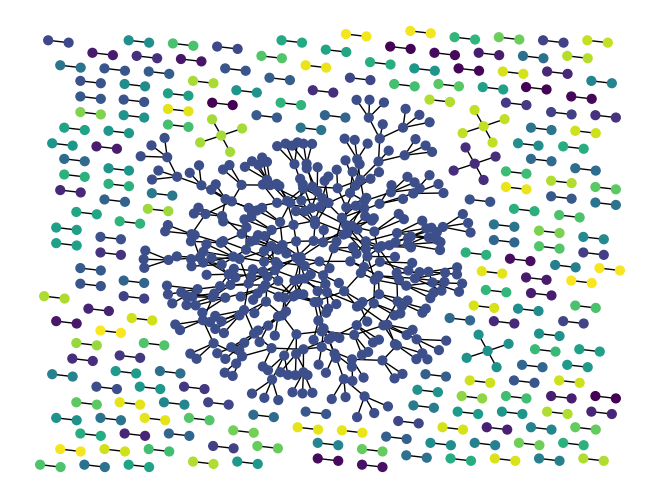

In [5]:
size, pi = 800, 0.2
graph = gen_rgm_biased(size, pi)

plot_graph(graph)

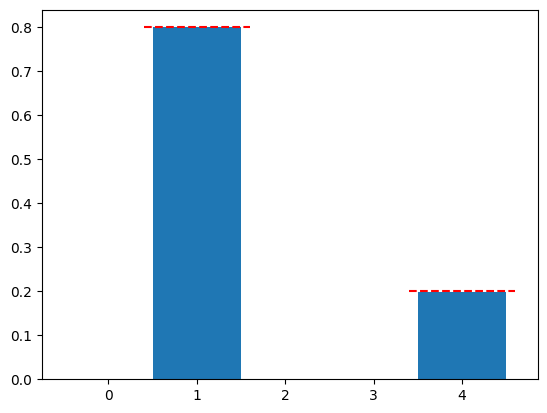

In [6]:
degree_list = [graph.degree[i] for i in range(len(graph))]

plt.hist(degree_list, density=True, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.plot([0.4, 1.6], [1-pi, 1-pi], 'r--')
plt.plot([3.4, 4.6], [pi,   pi],   'r--')
#plt.yscale('log')
plt.show()

## Problem 2: The giant component

We first need a function that (recursivly) walks through a graph to get the connected component starting from a given node:

In [7]:
def get_connected_component(graph, node, visited=None):
    if visited is None:
        visited = []
    visited.append(node)
    
    for neighbor in graph.neighbors(node):
        if neighbor not in visited:
            connected = get_connected_component(graph, neighbor, visited)
            
            for connected_node in connected:
                if connected_node not in visited:
                    visited.append(connected_node)
    return visited

We then use this function to efficently go through connected components (once per connected components), and return the largest connected components once there is not enough nodes to hope to find another even larger connected component:

In [8]:
def find_largest_connected_component(graph):
    n_nodes     = graph.number_of_nodes()
    not_visited = list(graph.nodes)
    
    largest_connected_component = []
    while True:
        starting_node = not_visited[0]
        connected_component = get_connected_component(graph, starting_node)

        for node in connected_component:
            not_visited.remove(node)

        if len(connected_component) >= len(largest_connected_component):
            largest_connected_component = connected_component
            
        if len(not_visited) <= len(largest_connected_component):
            return largest_connected_component

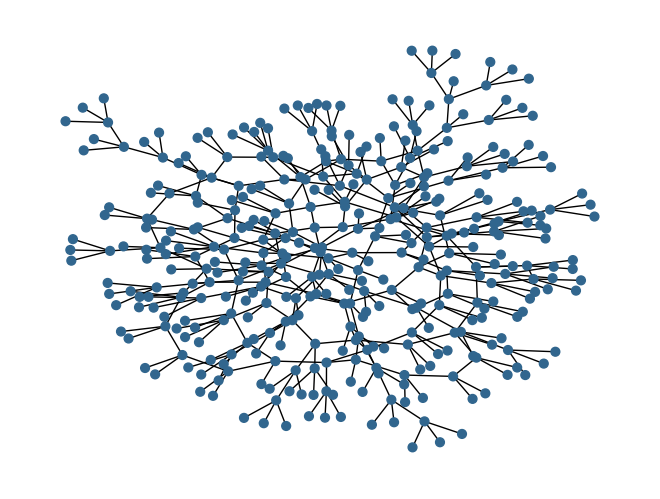

In [9]:
largest_connected_component = find_largest_connected_component(graph)
largest_connected_subgraph = graph.subgraph(largest_connected_component)

plot_graph(largest_connected_subgraph)

(a) We can now plot the average proportion of nodes inside of the giant component versus the value of $\pi$:

We here use a depth first search as we recursively search through the graph.

In [10]:
Ns, sizes = [200, 20, 10], [20, 100, 500]
pis = np.linspace(0, 1, 15)

avg_size = []
for N,size in zip(Ns,sizes):
    avg_size.append([])
    for pi in pis:
        avg_size[-1].append(0)
        for n in range(N):
            graph = gen_rgm_biased(size, pi)
            largest_connected_component = find_largest_connected_component(graph)
            avg_size[-1][-1] += len(largest_connected_component)
        avg_size[-1][-1] /= N*size

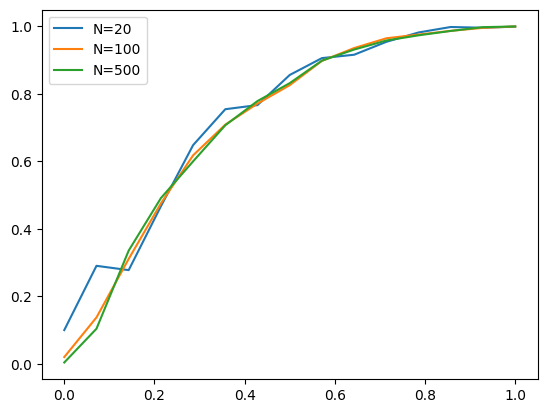

In [11]:
for size,curve in zip(sizes, avg_size):
    plt.plot(pis, curve, label=f"N={ size }")

plt.legend()
plt.show()

We observe that for increasing N (at least for our limited sample range) the curve doesn't evolve too much.

### 2-b: Theoretical analysis:

In this section, we study the statistics of the giant component of the graph. Let us first discuss the theory for this. Let us note $\pi$ the probability for a vertex to have degree 4 (as in the exam sheet). Let us suppose I am at node $i$ and I want to know with which probability is it ***not attached to the giant component***. This is the same as asking the probability for one of its neightbours to ***not be part of the giant component***. I have to sum the probability that each neightbour is connected to the giant component by one of its neigbours, except $i$. Let us write $\sigma$ the probability that a not node is attached to the giant component, knowing it is already connected with a link to another node. We will write $q_d$ the probability for a node to have degree $d$ conditined on the fact that it has already degree $1$. <br>
$$
\sigma = \sum_{d=0}^{+\infty} q_{q+1} \sigma^d  = q_1 + q_4 \sigma^3
$$
Now let us write $\gamma$ th probability for a node to ***be in the giant component***.<br>
$$
1 - \gamma = \sum_{q=0}^{+\infty} p_d \sigma^d = p_1 + p_4 \sigma^4
$$
We have by definition:
$$
q_d = \frac{d p_d}{\sum_{q=0}^{+\infty} d p_d}\\
q_1 = \frac{1-\pi}{1+3\pi}\\
q_4 = \frac{4\pi}{1+3\pi}\\
$$
We deduce the equations:
$$
\gamma = 1 - \sigma \left[ \left( 1 -\pi \right) + \pi \sigma^3 \right] \\
0 = 1 - \pi - \left( 1+3 \pi \right) \sigma + 4 \pi \sigma^3\\
0 = \left( \sigma -1 \right) \left( 4 \pi \sigma^2 + 4 \pi \sigma - \left( 1 - \pi \right) \right) 
$$

We can compute the solutions of the system as:
$$
\sigma = 1\\
\sigma = \frac{-1 \pm \frac{1}{\sqrt{\pi}}}{2}
$$
and 
$$
\gamma = 0\\
$$
$$
\gamma = 1 - \frac{ - 1 \pm \frac{1}{ \sqrt{\pi} } }{2} \left( 1 - \pi + \pi \left( \frac{-1 \pm \frac{1}{\sqrt{\pi} } }{2} \right)^3 \right)
$$
The solution must be a probability $\gamma, \sigma \in \left[0, 1\right]$. So we will only keep the solutions:
$$
\sigma = 0 \\
\sigma = \frac{\frac{1}{\sqrt{\pi}}-1}{2}
$$
We implement the expression for $\gamma$ in the next cell with a function called ```p_giant```.

In [12]:
def p_giant(pi):
    eps = 1e-18
    if pi == 0:
        return 0
    
    return max(0,
               1 - (1/np.sqrt(pi) - 1)/2 * (1 - pi + pi*((1/np.sqrt(pi) -1 ) / 2)**3))

(c) We can now compare the theoretical giant component size with our experimental results:

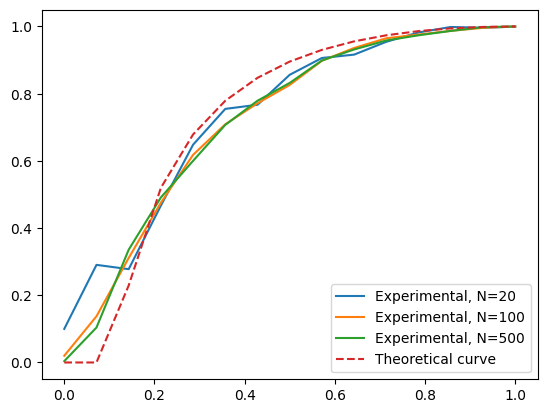

In [13]:
for size,curve in zip(sizes, avg_size):
    plt.plot(pis, curve, label=f"Experimental, N={ size }")

plt.plot(pis, [p_giant(pi) for pi in pis], "--", label="Theoretical curve")

plt.legend()
plt.show()

We see that the experimental curbe is non-zero for small p whereas our theoretically derived curve is zero for $\pi < \pi_0$ with some $\pi_0 > 0$.

We also observe that for all the N with tested, for small $\pi$ our experimental results gives us bigger average giant connected component, wheareas for $\pi$ closer to 1 we see the oposit with a higher theoreticl prediction.

We still observe the same quantization effect.

### Problem 3: Emergence of the 3-core

In [14]:
# we use the prunning algorithm we saw in class:
def find_k_core(graph, k):
    G = copy.deepcopy(graph)
    while True:
        to_remove=[]
        
        for node in G.nodes:
            if G.degree[node] < k:
                to_remove.append(node)
            
        if len(to_remove) == 0:
            if len(G.nodes) == 0:
                return []
            
            # the k-core still has to be a single connected graph
            k_core = find_largest_connected_component(G)
            return k_core

        for node in to_remove:
            G.remove_node(node)

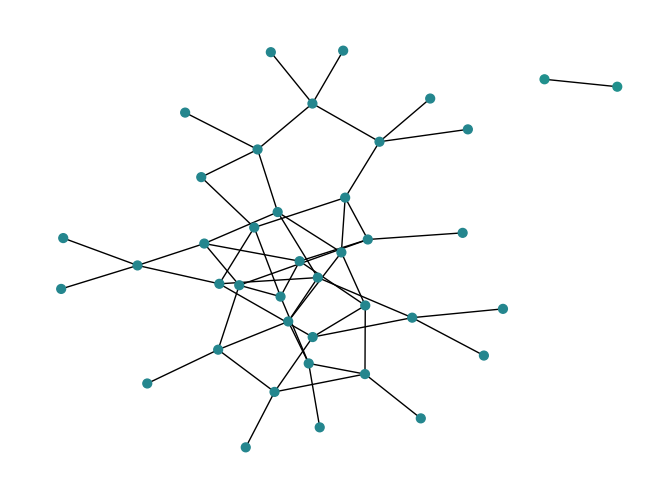

In [15]:
graph = gen_rgm_biased(40, 0.6)

plot_graph(graph)

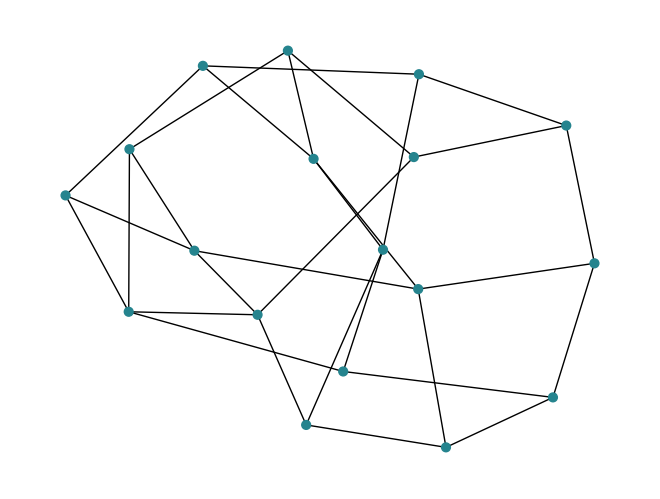

In [16]:
core3_component = find_k_core(graph, 3)
core3_subgraph = graph.subgraph(core3_component)

plot_graph(core3_subgraph)

(a) We can now plot the average proportion of nodes inside of the giant component versus the value of $\pi$:

In [17]:
Ns, sizes = [200, 100, 30], [20, 100, 500]
pis = np.linspace(0, 1, 15)

avg_size_3core = []
for N,size in zip(Ns,sizes):
    avg_size_3core.append([])
    for pi in pis:
        avg_size_3core[-1].append(0)
        for n in range(N):
            graph = gen_rgm_biased(size, pi)
            k_core = find_k_core(graph, 3)
            avg_size_3core[-1][-1] += len(k_core)
        avg_size_3core[-1][-1] /= N*size

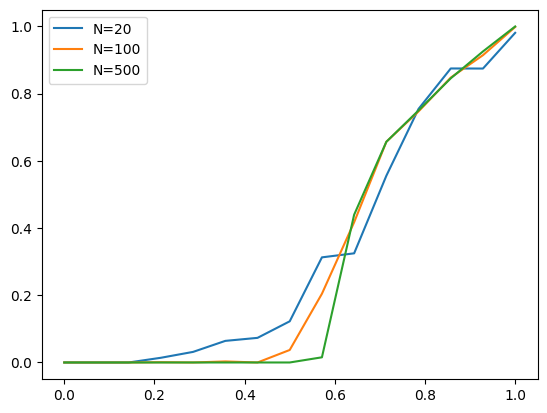

In [18]:
for size,curve in zip(sizes, avg_size_3core):
    plt.plot(pis, curve, label=f"N={ size }")

plt.legend()
plt.show()

W

### 3-b: Theoretical analysis:

We have seen in the course about the q-core that the typical probability that a randomly picked vertex is part of the three core is :
 -  $ F_{q}(\beta_f) = 1 - \sum_{d=0}^{q-1} e^{-\beta_f} \frac{\beta_f^d}{d !} $ 
<br> where $\beta_f$ is the fixed point of the map <br>
 - $ \frac{ \beta_{i+1} }{c} = F_{q-1} (\beta_{i}) $
 - c is the average degree of the evtexx of the graph: $c = \sum_{d=0}^{\infty} d p_d$

In the case of the configuration model we are considering here, the emergence of the three core is caracterised by:
 - $F_3 = 1 - e^{-\beta_f} \left( 1+ \beta_f + \frac{\beta_f^2}{2} \right)$
 - $ \frac{\beta_f}{1 + 3\pi} = 1 - e^{-\beta_f} \left( 1 + \beta_f \right) $
 - $ c = 1-\pi + 4\pi = 1 + 3 \pi $

Below we present a function that returns the relative size of the three core and the value of the parameter $\beta$ as $\left( F_3, \beta \right)$ and we plot $ \frac{\beta_f}{1 + 3\pi} $ and $F_2(\beta)$ for diferent values of $\pi$.

In [19]:
def Three_Core_Theory(pi):
    '''
    Returns a tuples F_3 and beta_f (see text above for the definition of these variables)
    '''
    F2 = lambda x: ( 1 - np.exp(-x) * ( 1 + x ) )
    F3 = lambda x: ( 1 - np.exp(-x) * ( 1 + x + x*x*0.5) )
    Beta_C = lambda x,pi: x / (1+3*pi)

    # func is the functions we need to find the zero, fprime and fpprime its first and second derivatives.
    func = lambda x,pi: Beta_C(x, pi) - F2(x)
    fprime = lambda x,pi: 1 / (1 + 3 * pi) - ( np.exp(-x) * x )
    fpprime = lambda x, pi: np.exp(-x)*(x - 1)

    try:
        Beta = opt.newton(func, 4., fprime=fprime, fprime2=fpprime, args=(pi,))
    except RuntimeError: # If the newton method does not achieve to find the zero, we know that 0,0 is always a solutions.
        return 0., 0.

    return F3(Beta), Beta

(c) We can now compare the theoretical giant component size with our experimental results:

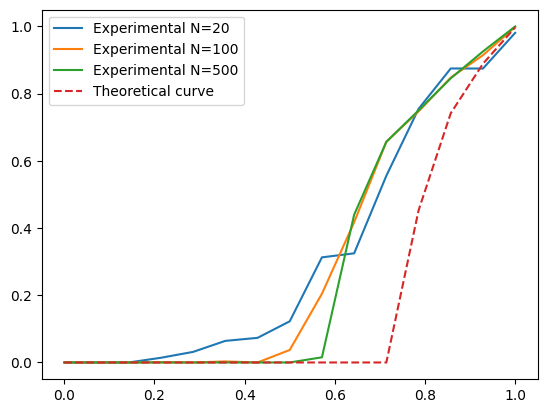

In [20]:
for size,curve in zip(sizes, avg_size_3core):
    plt.plot(pis, curve, label=f"Experimental N={ size }")

plt.plot(pis, [Three_Core_Theory(pi)[0]*3/2 for pi in pis], "--", label="Theoretical curve")

plt.legend()
plt.show()

We see that for higher N the $\pi_0$ at which the 3-core emerges (the average size of the 3 core becomes non-zero) is pushed toward the high-$\pi$, and thus toward our theoretically-derrived curve.

### Problem 4: The ferromagnetic Ising model

In [21]:
def gen_random_state(N_node, p=0.5):
    random_state = np.random.rand(N_node)
    state = 2*(random_state < p) - 1
    return state

def get_state_magnetisation(state):
    return np.mean(state)

In [22]:
def monte_carlo_simulate(graph, state, T, N_it_per_node):
    n_nodes = graph.number_of_nodes()
    
    for i in range(n_nodes*N_it_per_node):
        node = np.random.randint(0, n_nodes)
        
        total_surounding_spin = 0
        for neighbor in graph.neighbors(node):
            total_surounding_spin += state[neighbor]
        
        delta_E = 2*state[node]*total_surounding_spin
        if delta_E < 0:
            state[node] = -state[node]
        else:
            P_flip = np.exp(-delta_E/T)
            if np.random.rand() < P_flip:
                state[node] = -state[node]
        
    return state

In [23]:
graph = gen_rgm_biased(100, 0.8)
state = gen_random_state(100)

print(get_state_magnetisation(monte_carlo_simulate(graph, state, 10, 100)))
print(get_state_magnetisation(monte_carlo_simulate(graph, state, 0.5, 100)))

-0.32
-0.94


(1) TODO

In [24]:
N, size, n_it = 10, 50, 100
pis = np.linspace(0, 1, 20)
Ts  = np.linspace(0.5, 5, 20)

PIS, TS = np.meshgrid(pis, Ts)

avg_m = np.zeros_like(PIS)
for i in range(PIS.shape[0]):
    for j in range(PIS.shape[1]):
        for n in range(N):
            graph = gen_rgm_biased(size, PIS[i, j])
            state = gen_random_state(size)
            
            equilibirum_state = monte_carlo_simulate(graph, state, TS[i, j], n_it)
            
            avg_m[i, j] += abs(get_state_magnetisation(equilibirum_state))
avg_m /= N

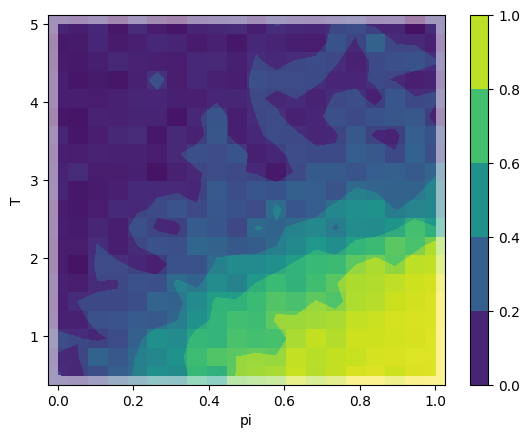

In [25]:
plt.contourf(PIS, TS, avg_m, 5)
plt.colorbar()
plt.pcolormesh(PIS, TS, avg_m, alpha=0.5)

plt.xlabel("pi")
plt.ylabel("T")
plt.show()

(2) TODO

(3) TODO

### Problem 5: Inverse Ising model

(1) TODO

In [26]:
size, T, pi = 50, 4, 0.4
N, n_it = 500, 100

graph = gen_rgm_biased(size, pi)

In [27]:
states = np.zeros((N, size))
for n in range(N):
    state = gen_random_state(size)
    equilibirum_state = monte_carlo_simulate(graph, state, T, n_it)
    states[n, :] = equilibirum_state

In [28]:
correlations = np.zeros((size, size))
avgs = np.mean(states, axis=0)

for i in range(size):
    for j in range(i): # range(i + 1), force corr[i, i] = 0 so self edges are ignored
        for n in range(N):
            correlations[i, j] += states[n, i]*states[n, j]
        correlations[i, j] /= N
        
        correlations[i, j] -= avgs[i]*avgs[j]
        correlations[j, i]  = correlations[i, j]

pairs = []
for i in range(size):
    for j in range(i):
        pairs.append((i, j))
cor_pairs = zip([correlations[pair] for pair in pairs], pairs)
cor_pairs_sorted = reversed(sorted(cor_pairs))
pairs_sorted = [pair for cor,pair in cor_pairs_sorted]

In [29]:
n_predictions = np.arange(1, int(graph.number_of_edges()*2))
prediction_acc = np.zeros_like(n_predictions, dtype=float)

for i in range(len(n_predictions)):
    for pair in pairs_sorted[:n_predictions[i]]:
        prediction_acc[i] += float(graph.has_edge(pair[0], pair[1]))
    prediction_acc[i] = float(prediction_acc[i])/n_predictions[i]

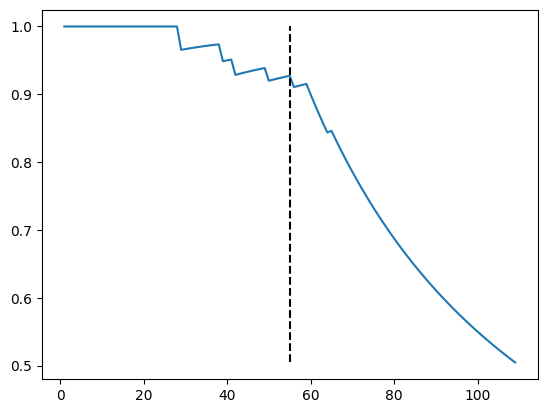

In [30]:
plt.plot(n_predictions, prediction_acc)
plt.plot([graph.number_of_edges(), graph.number_of_edges()], [min(prediction_acc), max(prediction_acc)], "k--")
plt.show()

(2) TODO

(3) TODO